In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import copy

# 1. Preparation

## 1.1. Dataset Wrapper

In [2]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

        self.X = self.X.unsqueeze(1) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## 1.2. Model Preparation

In [23]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# 2. Main Pipeline

In [24]:
class FPTPredictionPipeline:
    def __init__(self, target_col, hidden_size=64, num_layers=2, learning_rate=0.001, batch_size=64, dropout=0.2):
        self.target_col = target_col
        self.batch_size = batch_size
        self.lr = learning_rate
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.scaler = StandardScaler()
        self.model = None
        self.best_model_state = None

    def preprocess_data(self, df, train_ratio=0.7, val_ratio=0.15):
        print(f"--- [1] Data Preprocessing on Device: {self.device} ---")

        data = df.copy()
        if 'date' in data.columns:
            data['date'] = pd.to_datetime(data['date'])
            data = data.sort_values('date').set_index('date')

        # --- Chia biến target và features ---
        feature_cols = [c for c in data.columns if c != self.target_col]
        print(f"Features ({len(feature_cols)}): {feature_cols}")
        
        X = data[feature_cols].values
        y = data[self.target_col].values

        # --- Chia tập Train/Val/Test ---
        n = len(data)
        train_end = int(n * train_ratio)
        val_end = int(n * (train_ratio + val_ratio))

        X_train, y_train = X[:train_end], y[:train_end]
        X_val, y_val = X[train_end:val_end], y[train_end:val_end]
        X_test, y_test = X[val_end:], y[val_end:]

        print(f"Data Split -> Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

        # --- Scaling ---
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)
        
        self.input_dim = X_train_scaled.shape[1]

        # --- Tạo DataLoader ---
        train_loader = DataLoader(StockDataset(X_train_scaled, y_train), batch_size=self.batch_size, shuffle=False)
        val_loader = DataLoader(StockDataset(X_val_scaled, y_val), batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(StockDataset(X_test_scaled, y_test), batch_size=self.batch_size, shuffle=False)
        
        return train_loader, val_loader, test_loader

    def train(self, train_loader, val_loader, epochs=100, patience=10):
        print(f"--- [2] Start Training (Patience: {patience}) ---")
        self.model = LSTMModel(self.input_dim, self.hidden_size, self.num_layers, dropout=self.dropout).to(self.device)
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()
        
        history = {'train_loss': [], 'val_loss': []}
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            # --- TRAIN PHASE ---
            self.model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            avg_train_loss = train_loss / len(train_loader)
            
            # --- VAL PHASE ---
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                    outputs = self.model(X_batch)
                    loss = criterion(outputs, y_batch)
                    val_loss += loss.item()
            
            avg_val_loss = val_loss / len(val_loader)
            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)

            # --- CHECKPOINT & EARLY STOPPING ---
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                self.best_model_state = copy.deepcopy(self.model.state_dict()) # Lưu lại weight tốt nhất
                save_msg = "[Saved Best Model]"
            else:
                patience_counter += 1
                save_msg = ""

            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} {save_msg}")
            
            if patience_counter >= patience:
                print(f"!!! Early Stopping triggered at epoch {epoch+1} !!!")
                break
        
        # Load lại model tốt nhất trước khi kết thúc
        if self.best_model_state:
            self.model.load_state_dict(self.best_model_state)
            print("--- Training Completed. Best model loaded. ---")
            
        return history

    def evaluate(self, loader, dataset_name="Test"):
        """Đánh giá model trên tập bất kỳ (Test/Val)"""
        print(f"--- [3] Evaluating on {dataset_name} Set ---")
        self.model.eval()
        preds, actuals = [], []
        
        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch = X_batch.to(self.device)
                outputs = self.model(X_batch)
                preds.extend(outputs.cpu().numpy().flatten())
                actuals.extend(y_batch.numpy().flatten())
        
        # Metrics
        rmse = np.sqrt(mean_squared_error(actuals, preds))
        mae = mean_absolute_error(actuals, preds)
        r2 = r2_score(actuals, preds)
        
        print(f"Results for {dataset_name}:")
        print(f"RMSE: {rmse:.5f}")
        print(f"MAE : {mae:.5f}")
        print(f"R2  : {r2:.5f}")
        
        return pd.DataFrame({'Actual': actuals, 'Predicted': preds})

    def visualize(self, result_df, history=None):
        """Vẽ biểu đồ Loss và Kết quả dự đoán"""
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Training History
        if history:
            plt.subplot(2, 1, 1)
            plt.plot(history['train_loss'], label='Train Loss')
            plt.plot(history['val_loss'], label='Validation Loss', color='orange')
            plt.title('Training & Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('MSE Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        # Plot 2: Prediction vs Actual
        plt.subplot(2, 1, 2)
        plt.plot(result_df.index, result_df['Actual'], label='Actual', color='blue', alpha=0.6)
        plt.plot(result_df.index, result_df['Predicted'], label='Predicted', color='red', linestyle='--', alpha=0.8)
        plt.title('Prediction Performance (Test Set)')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# 3. Pipeline

In [25]:
df = pd.read_csv(r'..\..\data\predictive_modeling.csv', index_col='date')
df.head()

,fpt_stock_price_log_return_scaled,market_cap_log_return,fpt_stock_price_log_return,gdp_value,cpi_rate,fpt_stock_price,fpt_stock_volume_log_return,fpt_net_revenue_log_return,usd_vnd_rate_log_return,xau_usd_rate_log_return
date,,,,,,,,,,
2020-01-01,-0.055765,0.0,0.000000,3.466157e+11,0.0643,21.39,0.000000,0.0,0.000194,0.009066
2020-01-02,-0.055765,0.0,0.000000,3.466157e+11,0.0643,21.39,0.000000,0.0,0.000194,0.009066
2020-01-03,-1.040504,0.0,-0.016974,3.466157e+11,0.0643,21.03,0.825817,0.0,-0.000043,0.014361
2020-01-06,-0.665883,0.0,-0.010516,3.466157e+11,0.0643,20.81,-0.629106,0.0,0.000151,0.018648
2020-01-07,1.048811,0.0,0.019039,3.466157e+11,0.0643,21.21,-0.265344,0.0,0.000043,-0.003361


In [26]:
cols_to_drop = ['fpt_stock_price', 'fpt_stock_price_log_return_scaled']
df_clean = df.drop(columns=cols_to_drop, errors='ignore')
print("Các cột còn lại sau khi drop:\n", df_clean.columns)

Các cột còn lại sau khi drop:
 Index(['market_cap_log_return', 'fpt_stock_price_log_return', 'gdp_value',
       'cpi_rate', 'fpt_stock_volume_log_return', 'fpt_net_revenue_log_return',
       'usd_vnd_rate_log_return', 'xau_usd_rate_log_return'],
      dtype='object')


In [27]:
pipeline = FPTPredictionPipeline(
    target_col='fpt_stock_price_log_return',
    hidden_size=64,
    num_layers=2,
    batch_size=32,
    learning_rate=0.001,
    dropout=0.25
)

In [28]:
train_loader, val_loader, test_loader = pipeline.preprocess_data(df_clean, train_ratio=0.7, val_ratio=0.15)

--- [1] Data Preprocessing on Device: cuda ---
Features (7): ['market_cap_log_return', 'gdp_value', 'cpi_rate', 'fpt_stock_volume_log_return', 'fpt_net_revenue_log_return', 'usd_vnd_rate_log_return', 'xau_usd_rate_log_return']
Data Split -> Train: 1070 | Val: 229 | Test: 230


In [40]:
history = pipeline.train(train_loader, val_loader, epochs=200, patience=30)

--- [2] Start Training (Patience: 30) ---
Epoch 001/200 | Train Loss: 0.003473 | Val Loss: 0.000224 [Saved Best Model]
Epoch 005/200 | Train Loss: 0.000314 | Val Loss: 0.000217 [Saved Best Model]
Epoch 010/200 | Train Loss: 0.000298 | Val Loss: 0.000217 
Epoch 015/200 | Train Loss: 0.000316 | Val Loss: 0.000216 [Saved Best Model]
Epoch 020/200 | Train Loss: 0.000334 | Val Loss: 0.000216 [Saved Best Model]
Epoch 025/200 | Train Loss: 0.000349 | Val Loss: 0.000221 
Epoch 030/200 | Train Loss: 0.000325 | Val Loss: 0.000223 
Epoch 035/200 | Train Loss: 0.000303 | Val Loss: 0.000223 
Epoch 040/200 | Train Loss: 0.000303 | Val Loss: 0.000223 
Epoch 045/200 | Train Loss: 0.000304 | Val Loss: 0.000221 
Epoch 050/200 | Train Loss: 0.000318 | Val Loss: 0.000221 
!!! Early Stopping triggered at epoch 50 !!!
--- Training Completed. Best model loaded. ---


In [41]:
results = pipeline.evaluate(test_loader, dataset_name="TEST")

--- [3] Evaluating on TEST Set ---
Results for TEST:
RMSE: 0.02059
MAE : 0.01502
R2  : -0.26545


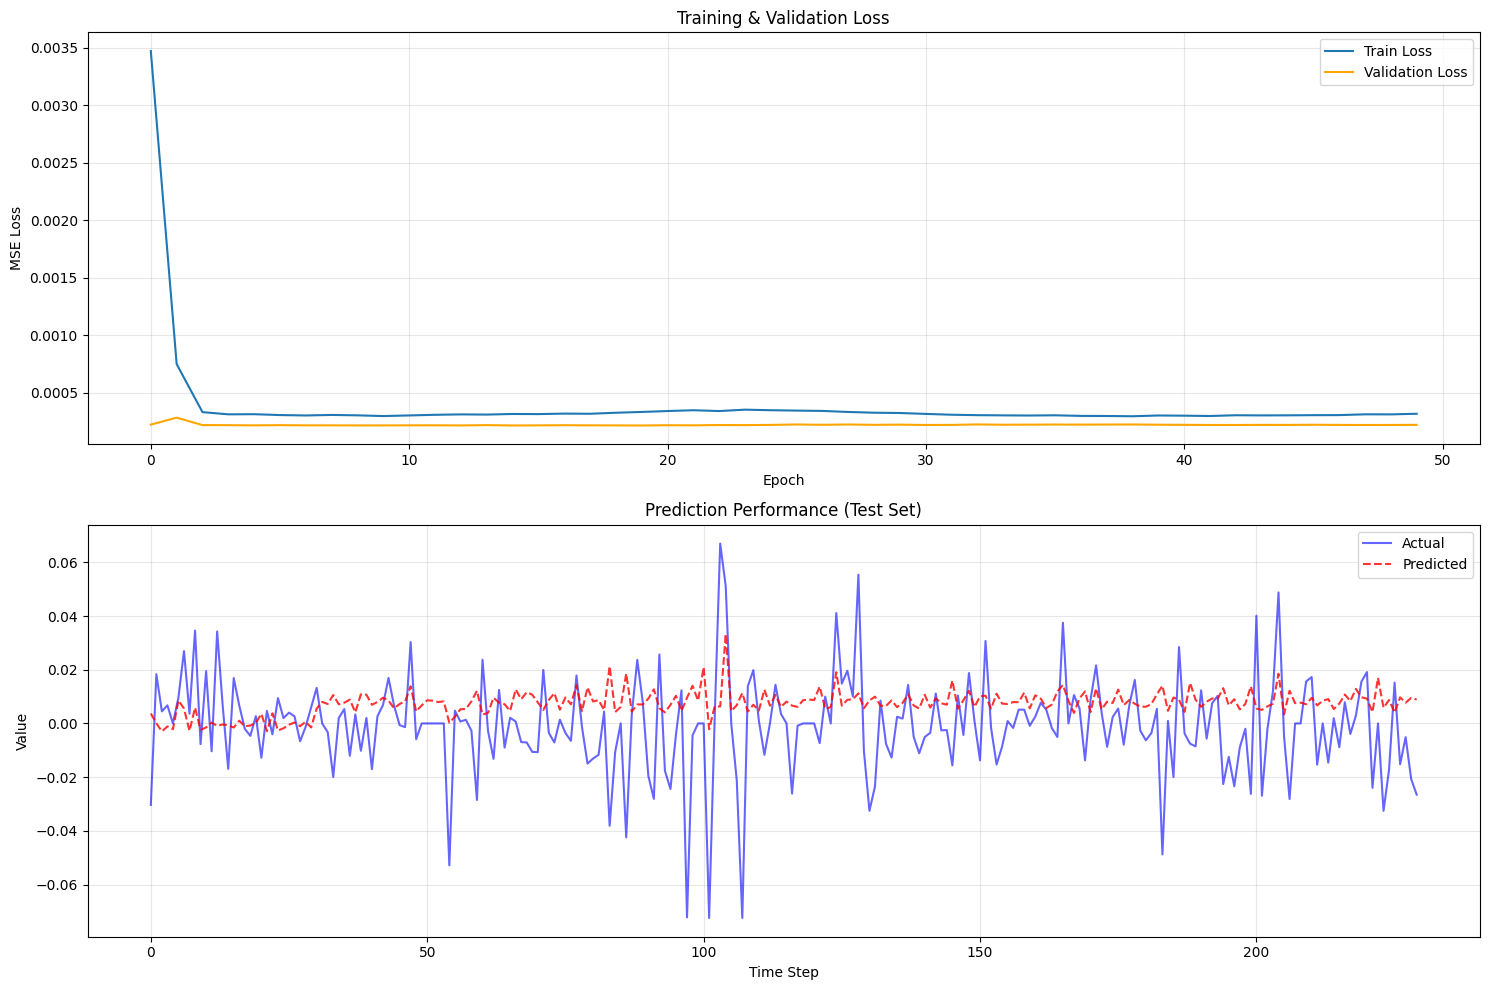

In [ ]:
pipeline.visualize(results, history)